<h1 align="center">Changes in English medication safety indicators throughout the COVID-19 pandemic: a federated analysis of 57 million patients’ primary care records in situ using OpenSAFELY
</h1>

Pharmacist-led information technology intervention (PINCER) is an effective way to reduce errors in prescription and medication monitoring which are responsible for a large proportion of adverse drug events. This is achieved through the monitoring of 13 PINCER indicators.

The purpose of this notebook is to describe practice level changes in adherence to each of the PINCER indicators  throughout the COVID-19 pandemic. For each indicator, the number of unique patients experiencing hazardous prescribing described by a given indicator at any point during the study period is provided. The total number of hazardous prescribing events for each indicator is also shown.  Practice level monthly rates of hazardous prescribing are calculated, ranked and used to calculate deciles of activity for each indicator, which are represented as decile charts.

This analysis is run across all patients in England registered at a General Practice using either TPP or EMIS as their EHR vendor. This covers 95% of the English population.




<ul id="docNav">
<p>The 13 PINCER measures include:</p>
<li> <a href="#gi_bleed">Gastrointestinal (GI) Bleed Indicators</a>
    <ul>
       <li> <a href="#a">Age 65+, on oral NSAID without gastroprotection (GI_P3A)</a> 
       <li> <a href="#b">H/O peptic ulcer, on oral NSAID without gastroprotection (GI_P3B)</a> 
       <li> <a href="#c">H/O peptic ulcer, on OAC without gastroprotection (GI_P3C)</a>
       <li> <a href="#d">On OAC and oral NSAID (GI_P3D)</a>
       <li> <a href="#e">On OAC and antiplatelet without gastroprotection (GI_P3E)</a>
       <li> <a href="#f">On aspirin and antiplatelet without gastroprotection (GI_P3F)</a>
    </ul>
<li> <a href="#monitoring">Monitoring Indicators</a>
    <ul>
       <li> <a href="#ac">Age 75+, on ACEI or loop, no renal function/electrolytes test (MO_P13)</a> 
       <li> <a href="#me">Methotrexate audit (MO_P15)</a> 
            <ul>
                <li> <a href="#me_no_fbc">On methotrexate without recorded full blood count (FBC)</a>
                <li> <a href="#me_no_lft">On methotrexate without recorded liver functon test (LFT)</a>
            </ul>
       <li> <a href="#li">On lithium without recent lithium test (MO_P17)</a>
       <li> <a href="#am">On amiodarone without recent thyroid function test (TFT) (MO_P18)</a>
    </ul>
<li> <a href="#gi_bleed">Gastrointestinal (GI) Bleed Indicators</a>
    <ul>
       <li> <a href="#g">Asthma and non-selective BB (AS_P3G)</a> 
       <li> <a href="#i">Heart failure and oral NSAID (HF_P3I)</a> 
       <li> <a href="#k">eGFR less than 45 and oral NSAID (KI_P3K) (TPP practices only)</a>
    </ul>
</ul>

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpllimg
import matplotlib as mpl
import json
import numpy as np
from IPython.display import HTML, display, Markdown, Image
import os


with open(f'../backend_outputs/combined_summary_statistics.json') as f:
        summary = json.load(f)

with open(f'../backend_outputs/combined_practice_count.json') as f:
    practice_count_event = json.load(f)["num_practices_event"]

with open(f'../backend_outputs/combined_practice_count.json') as f:
    practice_count = json.load(f)["num_practices"]

with open(f'../backend_outputs/medians.json') as f:
    medians = json.load(f)["summary"]

num_gi_bleed_events = 0
num_monitoring_events = 0
num_other_events = 0


gi_bleed_indicators = ["a", "b", "c", "d", "e", "f"]
for i in gi_bleed_indicators:
    events = int(summary[i]['events'])
    num_gi_bleed_events += events

monitoring_indicators = ["ac", "me_no_fbc", "me_no_lft", "li", "am"]
for i in monitoring_indicators:
    events = int(summary[i]['events'])
    num_monitoring_events += events

other_prescribing_indicators = ["g", "i", "k"]
for i in other_prescribing_indicators:
    events = int(summary[i]['events'])
    num_other_events += events

def show_summary(indicator):
    display(
    Markdown(f"Number of practices with at least one hazardous prescribing event throughout the study period: {summary[indicator]['num_practices']} ({summary[indicator]['percent_practice']}%)"),
    Markdown(f"Number of unique patients at risk of a hazardous prescribing event throughout the study period: {summary[indicator]['patients_denominator']:,}"),
    Markdown(f"Number of unique patients experiencing at least one hazardous prescribing event throughout the study period: {summary[indicator]['patients_numerator']:,}"),
    Markdown(f"Number of hazardous prescribing events throughout the study period: {int(summary[indicator]['events']):,}"),
    Markdown(f"Q1 2020 mean proportion: {round(medians[indicator]['pre'], 4)}"),
    Markdown(f"Q1 2021 mean proportion: {round(medians[indicator]['post'], 4)}")
       
       )
        
def show_image(path):

    img=Image(path)
    display(img)

## Summary

In [18]:
indicator_order = ['gi_bleed','a','b','c','d','e','f', 'monitoring','ac','me_no_fbc','me_no_lft','li','am','other','g','i','k']
column_names = {"pre": "Q1 mean percentage 2020",
                "post": "Q1 mean percentage 2021",
                "patients_numerator": "Numerator",
                "patients_denominator": "Denominator",
                "ratio": "%",
                "events_per_patient": "Ratio of hazardous prescribing events to unique patients experiencing an event",
                "num_practices": "Number of practices with at least one hazardous prescribing event",
                "percent_practice": "% of total number of practices",
                }
title_mapping = {
    "a": "Age >= 65 & NSAID",  # "NSAID without gastroprotection, age >=65",
    "b": "PU & NSAID",  # "NSAID without gastroprotection, H/O peptic ulcer",
    "c": "PU & antiplatelet",  # "Antiplatelet without gastroprotection, H/O peptic ulcer",
    "d": "Warfarin/DOAC & NSAID",  # "DOAC with warfarin",
    # "Anticoagulation and antiplatelet, no gastroprotection",
    "e": "Warfarin/DOAC & antiplatelet",
    # "Aspirin and antiplatelet, no gastroprotection",
    "f": "Aspirin & other antiplatelet",
    "g": "Asthma & beta-blocker",  # "Asthma and non-selective beta-blocker",
    "i": "HF & NSAID",  # "Heart failure and NSAID",
    "k": "CRF & NSAID",  # "Chronic renal impairment and NSAID",
    # "ACE inhibitor or loop diuretic without renal function/electrolyte test",
    "ac": "ACEI or loop diuretic, no blood tests",
    # "Methotrexate without full blood count",
    "me_no_fbc": "Methotrexate and no FBC",
    # "Methotrexate without liver function test",
    "me_no_lft": "Methotrexate and no LFT",
    # "Lithium without lithium concentration test",
    "li": "Lithium and no level recording",
    "am": "Amiodarone and no TFT",  # "Amiodarone without thyroid function test",
    ### Summary categories
    "gi_bleed": "Indicators associated with gastrointestinal bleeding",
    "monitoring": "Indicators associated blood test monitoring",
    "other": "Indicators associated with cautioned medication in other conditions (including heart failure, asthma and acute kidney injury)",
}

def generate_summary_table():

    summary_table = pd.DataFrame.from_dict(summary).T.reindex(indicator_order)
    medians_table = pd.DataFrame.from_dict(medians).T.reindex(indicator_order).round(2)

    summary_table_out = (summary_table
                         .assign(patients_numerator=pd.to_numeric(summary_table.patients_numerator, downcast="integer"))
                         .assign(patients_denominator=pd.to_numeric(summary_table.patients_denominator, downcast="integer"))
                         .assign(num_practices=pd.to_numeric(summary_table.num_practices, downcast="integer"))
                         )

    ### Missing values mean that we can't use the above method to convert the event count to integers
    summary_table_out['events'] = summary_table_out['events'].astype('Int64')
    summary_table_out['ratio'] = round(
        100%(summary_table_out['patients_numerator']/summary_table_out['patients_denominator']), 2)
    summary_table_out['events_per_patient'] = round(
        (summary_table_out['events']/summary_table_out['patients_numerator']), 2)

    practice_string = summary_table_out.num_practices.map(
        str) + " (" + summary_table_out.percent_practice.map(str) + "%)"
    practice_string[np.isnan(summary_table_out.percent_practice)] = "-"
    summary_table_out['practice_string'] = practice_string

    final_table = summary_table_out.join(medians_table)[column_names.keys()]

    final_table['patients_numerator'] = final_table['patients_numerator'].map('{:,}'.format)
    final_table['patients_denominator'] = final_table['patients_denominator'].map('{:,}'.format)
    final_table['percent_practice'] = final_table['percent_practice'].map('{:.2f}'.format)

    final_table_display = final_table.rename(columns=column_names, index=title_mapping)

    #Replace NA
    final_table_display = final_table_display.replace({np.nan: "-"})
    final_table_display = final_table_display.replace({"nan": "-"})
    
    display(final_table_display)

generate_summary_table()

,Q1 mean percentage 2020,Q1 mean percentage 2021,Numerator,Denominator,%,Ratio of hazardous prescribing events to unique patients experiencing an event,Number of practices with at least one hazardous prescribing event,% of total number of practices
Indicators associated with gastrointestinal bleeding,-,-,"551,844","10,881,675",0.04,-,6335,-
Age >= 65 & NSAID,1.11,0.75,"334,487","9,207,007",0.02,4.54,6304,0.03
PU & NSAID,1.32,1.07,"32,089","678,218",0.03,3.83,5801,0.03
PU & antiplatelet,4.24,3.85,"41,414","678,218",0.04,10.9,5943,0.03
Warfarin/DOAC & NSAID,1.39,1.18,"84,101","1,915,117",0.01,4.57,6193,0.03
Warfarin/DOAC & antiplatelet,2.26,1.67,"52,575","1,249,865",0.01,5.86,6068,0.03
Aspirin & other antiplatelet,1.67,1.2,"36,927","1,470,315",0.02,7.15,5777,0.03
Indicators associated blood test monitoring,-,-,"1,102,209","3,358,954",0.25,-,6329,-
"ACEI or loop diuretic, no blood tests",5.16,12.14,"850,587","3,095,595",0.26,5.89,6303,0.03
Methotrexate and no FBC,18.64,22.73,"164,502","238,042",0.49,5.05,6278,0.03


<a id="gi_bleed"></a>
## Gastrointestinal (GI) Bleed Indicators


<a id="a"></a>
### Age 65+, on oral NSAID without gastroprotection (GI_P3A)

Prescription of an oral NSAID in the previous 3 months to patients aged 65 or above who have been co-prescribed an ulcer healing drug in the previous 3 months.  

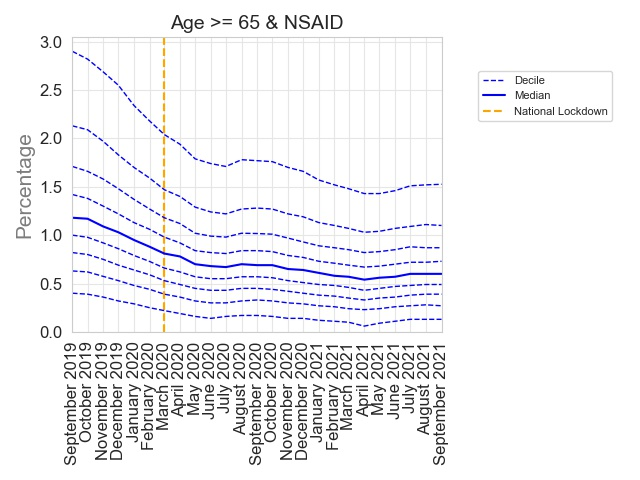

In [19]:
show_image("../backend_outputs/figures/plot_a.jpeg")

<a id="b"></a>
### H/O peptic ulcer, on oral NSAID without gastroprotection (GI_P3B)

Prescription of an oral NSAID in the previous 3 months to patients with a history of peptic ulceration/gastric bleed.

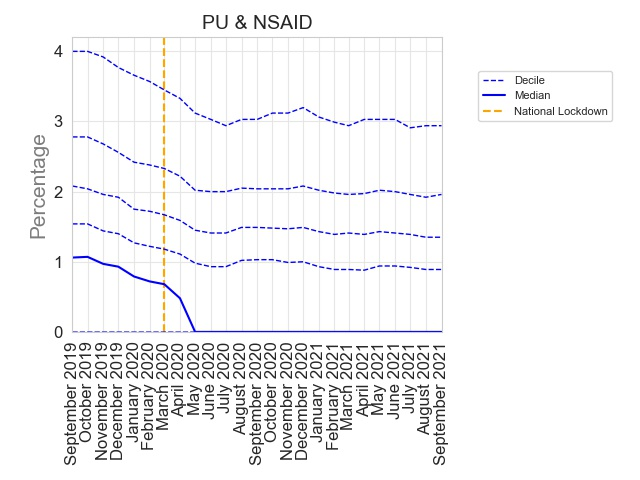

In [20]:
show_image("../backend_outputs/figures/plot_b.jpeg")



<a id="c"></a>
### H/O peptic ulcer, on OAC without gastroprotection (GI_P3C)

Prescription of an aniplatelet drug in the previous 3 months in patients with a history of peptic ulceration/gatric bleed.

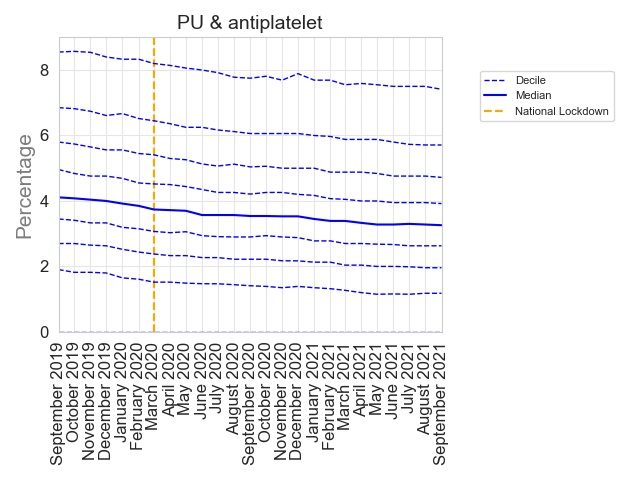

In [21]:
show_image("../backend_outputs/figures/plot_c.jpeg")

<a id="d"></a>
### On OAC and oral NSAID (GI_P3D)

Prescription of warfarin or a DOAC in the previous 3 months and a preascription of an oral NSAID in the previous 3 months.

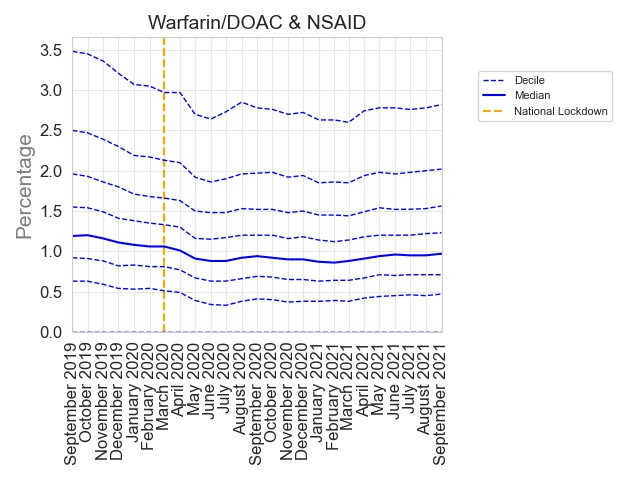

In [22]:
show_image("../backend_outputs/figures/plot_d.jpeg")

<a id="e"></a>
### On OAC and antiplatelet without gastroprotection (GI_P3E)

Prescription of warfarin or a DOAC in combination with an antiplatelet drug in the previous 3 months without co-prescription of an ulcer-healing drug.

Note: "In combination" is defined as a co-prescription within 28 days of each other.


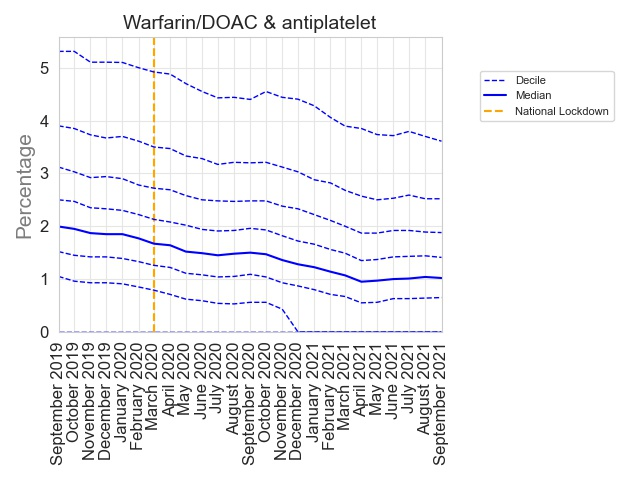

In [23]:
show_image("../backend_outputs/figures/plot_e.jpeg")

<a id="f"></a>
### On aspirin and antiplatelet without gastroprotection (GI_P3F)

Prescription of aspirin in combination with another antiplatelet drug in the previous 3 months without co-prescription of an ulcer-healing drug.

Note: "In combination" is defined as a co-prescription within 28 days of each other.

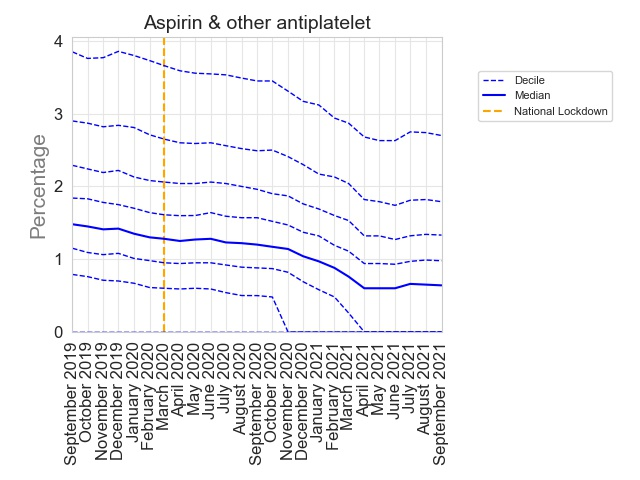

In [24]:
show_image("../backend_outputs/figures/plot_f.jpeg")

<a id="monitoring"></a>
## Monitoring Indicators

<a id="ac"></a>
### Age 75+, on ACEI or loop, no renal function/electrolytes test (MO_P13)

Absence of a computer-recorded check of renal function or electrolytes in the previous 15 months in patients aged 75 or over who have been prescripted an ACEi of loop diuretic in the previous 6 months.

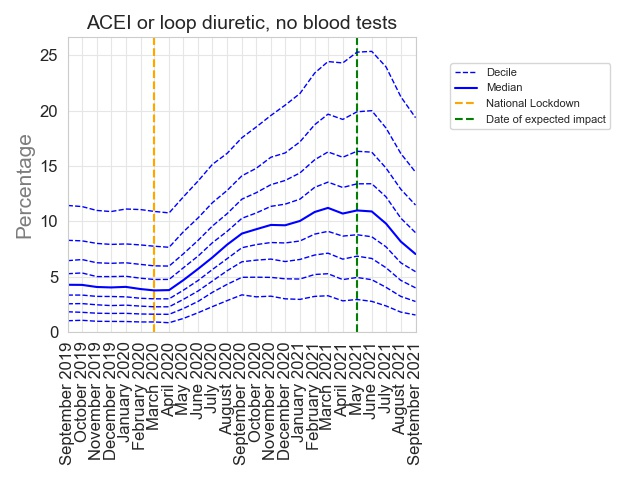

In [25]:
show_image("../backend_outputs/figures/plot_ac.jpeg")

<a id="me"></a>
### Methotrexate audit (MO_P15)

<a id="me_no_fbc"></a>
#### On methotrexate without recorded full blood count

Absence of a recorded full blood count in the previous 3 months in patients who have been receiving a methotrexate prescription for at least 3 months.

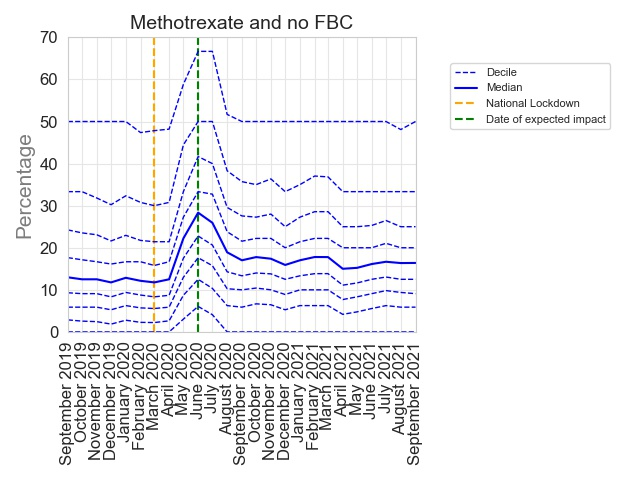

In [26]:
show_image("../backend_outputs/figures/plot_me_no_fbc.jpeg")

<a id="me_no_lft"></a>
#### On methotrexate without recorded liver function test

Absence of a recorded liver function test in the previous 3 months in patients who have been receiving a methotrexate prescription for at least 3 months.

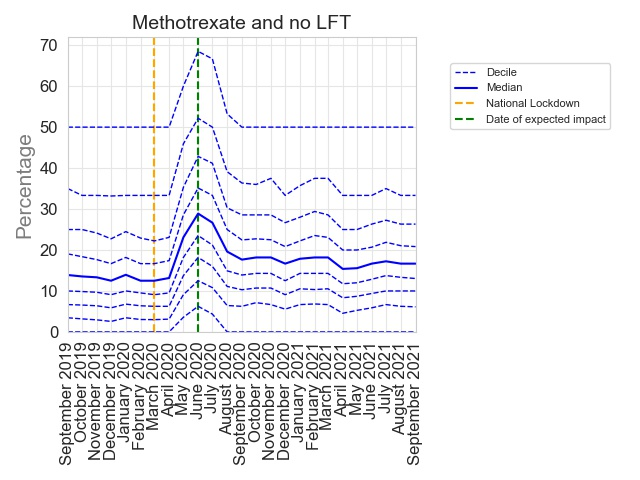

In [27]:
show_image("../backend_outputs/figures/plot_me_no_lft.jpeg")

<a id="li"></a>
### On lithium without recent lithium test (MO_P17)

Absence of a recorded check of lithium concentration in the previous 3 months in patients who have been receiving a lithium prescription for at least 3 months.

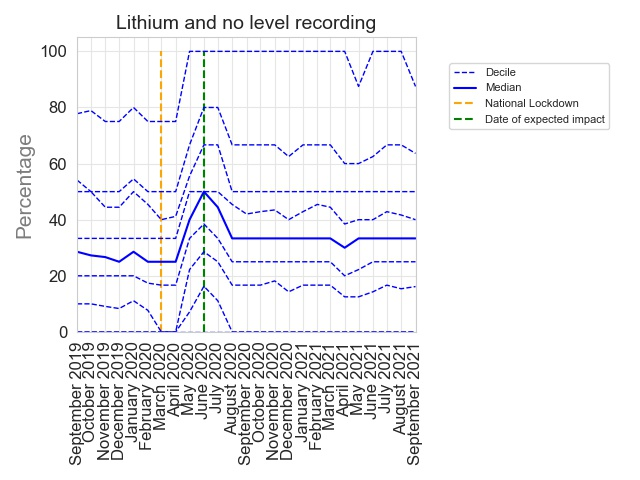

In [28]:
show_image("../backend_outputs/figures/plot_li.jpeg")

<a id="am"></a>
### On amiodarone without recent thyroid function test (MO_P18)

Absence of a recorded thyroid function test in the previous 6 months in patients who have been receiving a lithium prescription for at least 6 months.

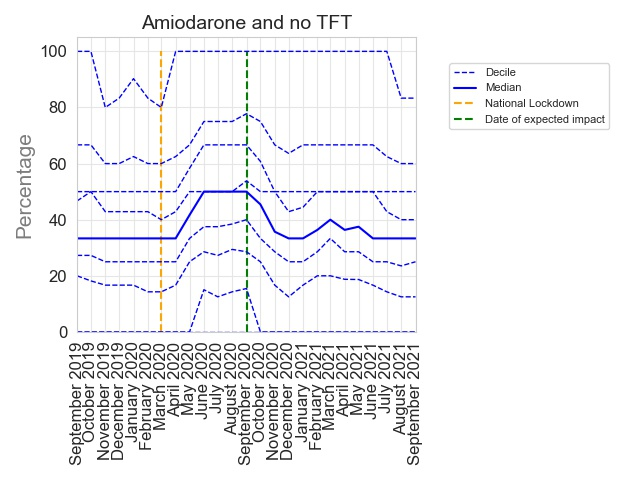

In [29]:
show_image("../backend_outputs/figures/plot_am.jpeg")

<a id="other"></a>
## Other Indicators


<a id="g"></a>
### Asthma and non-selective BB (AS_P3G)

Prescription of a non-selective beta-blocker in the previous 3 months in patients with a history of asthma.

Note: History of asthma is defined as patients with a recorded code for asthma without a more recent asthma resolved code.

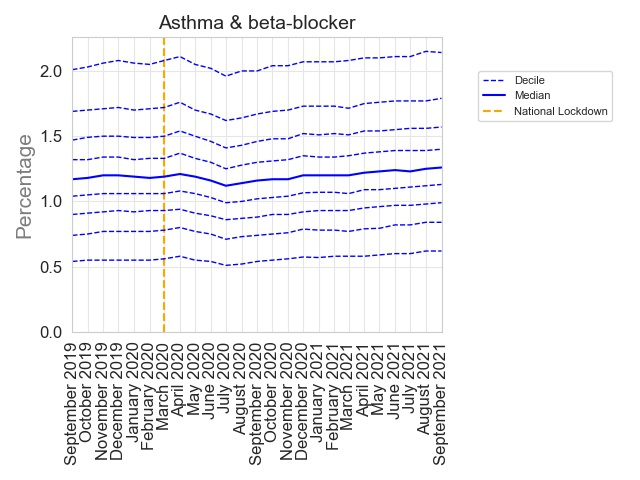

In [30]:
show_image("../backend_outputs/figures/plot_g.jpeg")

<a id="i"></a>
### Heart failure and oral NSAID (HF_P3I)

Prescription of an oral NSAID in the previous 3 months in patients with heart failure.

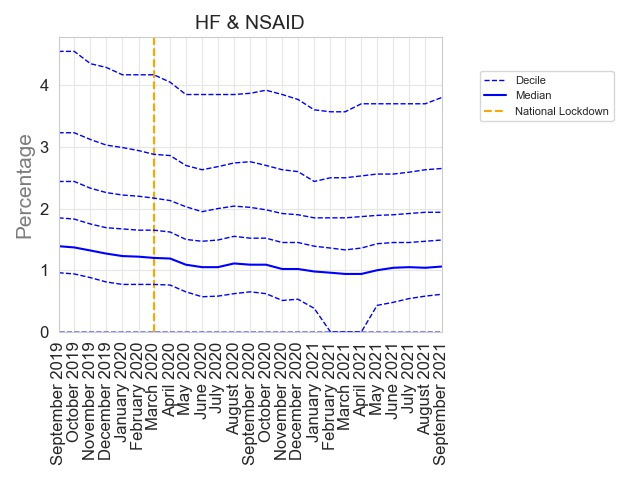

In [31]:
show_image("../backend_outputs/figures/plot_i.jpeg")

<a id="k"></a>
### eGFR <45 and oral NSAID (KI_P3K)

**NOTE**: The results below are for TPP practices only.

Prescription of an oral NSAID in the previous 3 months to patients with an eGFR < 45.

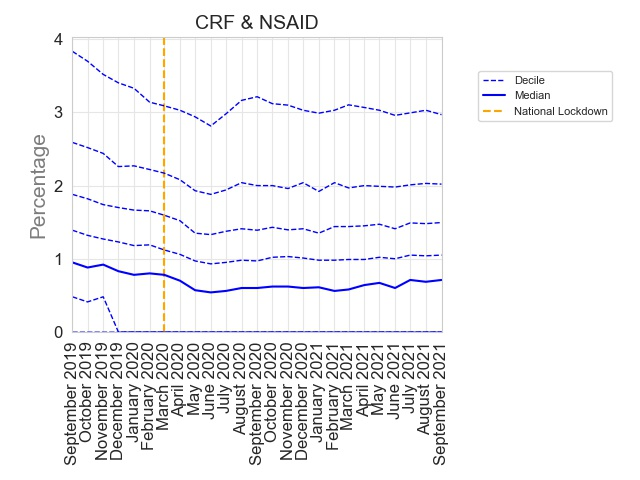

In [32]:
show_image("../backend_outputs/figures/plot_k.jpeg")